In [1]:
pip install pycountry



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import wbgapi as wb
import pandas as pd
import wbdata
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry
import json
## /// Altair. This is a way of visualiting Vega charts in Colab
%pip install altair   # Some packagaes need to be installed to the virtual machine before we can import them into our notebook. We can do this with '!pip install'
import altair as alt




[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
indicator = {"IC.BUS.EASE.DFRN.XQ.DB1719": "Ease of doing business score (DB17-20 methodology)"}
ease_df_17 = wbdata.get_dataframe(indicator, country=["USA", "GBR", "CHE","FRA","DEU","JPN","CHN","IND","BRA","RUS","ITA","ESP","KOR","AUS","CAN","SWE","ARE","COL","IDN","IRL",'EGY','SAU','MEX'])
indicator1 = {"IC.BUS.EASE.DFRN.DB16": "Ease of doing business score (DB15 methodology)"}
ease_df_15 = wbdata.get_dataframe(indicator1, country=["USA", "GBR", "CHE","FRA","DEU","JPN","CHN","IND","BRA","RUS","ITA","ESP","KOR","AUS","CAN","SWE","ARE","COL","IDN","IRL",'EGY','SAU','MEX'])
indicator2 = {"IC.BUS.EASE.DFRN.DB1014": "Ease of doing business score (DB10-14 methodology)"}
ease_df_10 = wbdata.get_dataframe(indicator2, country=["USA", "GBR", "CHE","FRA","DEU","JPN","CHN","IND","BRA","RUS","ITA","ESP","KOR","AUS","CAN","SWE","ARE","COL","IDN","IRL",'EGY','SAU','MEX'])
ease_df_10.head(10)
ease_df_15.reset_index(inplace=True)
ease_df_17.reset_index(inplace=True)
ease_df_10.reset_index(inplace=True)


In [4]:
#Merging all the data and filtering NAN. We have long format with all the countries and dates from 2009 onwards. 

ease_df = ease_df_17.merge(ease_df_15, on=['date','country'],how="inner")
ease_df['Ease_of_b']= ease_df['Ease of doing business score (DB17-20 methodology)'].combine_first(ease_df['Ease of doing business score (DB15 methodology)'])
ease_df.drop(columns=['Ease of doing business score (DB17-20 methodology)', 'Ease of doing business score (DB15 methodology)'], inplace=True)
ease_df = ease_df.merge(ease_df_10, on=['date','country'],how="inner")
ease_df['Ease_of_b']= ease_df['Ease_of_b'].combine_first(ease_df['Ease of doing business score (DB10-14 methodology)'])
ease_df.drop(columns='Ease of doing business score (DB10-14 methodology)', inplace=True)
ease_df.dropna(inplace=True)
ease_df['date']=pd.to_datetime(ease_df['date'])


#VERY COOL code to convert country names to ISO codes. Some might not work and it they don't return country name then you change them manually down there. 
def get_iso_code(country_name):
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except LookupError:
        return country_name

ease_df['country'] = ease_df['country'].apply(get_iso_code)
ease_df['country'] = ease_df['country'].str.replace('Korea, Rep.', 'KOR')
ease_df['country'] = ease_df['country'].str.replace('Egypt, Arab Rep.', 'EGY')


ease_df


,country,date,Ease_of_b
0,ARE,2019-01-01,80.75261
1,ARE,2018-01-01,81.58883
2,ARE,2017-01-01,79.30036
3,ARE,2016-01-01,77.43435
4,ARE,2015-01-01,76.28546
...,...,...,...
376,USA,2017-01-01,83.59008
377,USA,2016-01-01,83.58991
378,USA,2015-01-01,83.59247
379,USA,2014-01-01,82.58469


In [5]:
#We now need the data from innovation index. 


#First step is the hardest, finding the right URL, search documentation and test out directly on the web
url = "https://datacatalogapi.worldbank.org/dexapps/efi/data?datasetId=WIPO.GII&indicatorIds=WIPO.GII.235&countryCodes=USA, GBR, CHE,FRA,DEU,JPN,CHN,IND,BRA,RUS,ITA,ESP,KOR,AUS,CAN,SWE,ARE,COL,IDN,IRL,EGY,SAU,MEX,CHE,&attribute1=Rank&years=01/01/2013,01/01/2014,01/01/2015,01/01/2016,01/01/2017,01/01/2018,01/01/2019"

#fetch it
response = requests.get(url)
list = []
#check it to understand its structure
data = response.json()
for value in data.values():
    list = value


#This is way of filtering the data I need and having it in lists. Then I can manipulate it better. 
year = []
value = []
country = []
country_ISO=["USA", "GBR", "CHE","FRA","DEU","JPN","CHN","IND","BRA","RUS","ITA","ESP","KOR","AUS","CAN","SWE","ARE","COL","IDN","IRL",'EGY','SAU','MEX']
for i in range(161):
    for j in country_ISO:
        if list[i]['COUNTRY_CODE'] == j:
            country.append(list[i]['COUNTRY_CODE'])
            year.append(list[i]['CAL_YEAR'])
            value.append(list[i]['IND_VALUE'])
            break
innovation_df = pd.DataFrame({'country': country, 'year': year, 'innovation': value}) #cool way of turning a dictionary into a dataframe
innovation_df['year'] = pd.to_datetime(innovation_df['year'])

innovation_df


,country,year,innovation
0,ARE,2013-01-01,38.0
1,ARE,2014-01-01,36.0
2,ARE,2015-01-01,47.0
3,ARE,2016-01-01,41.0
4,ARE,2017-01-01,35.0
...,...,...,...
156,USA,2015-01-01,5.0
157,USA,2016-01-01,4.0
158,USA,2017-01-01,4.0
159,USA,2018-01-01,6.0


In [6]:
merge_df = ease_df.merge(innovation_df, left_on = ['country','date'], right_on =['country','year'], how ='inner')
merge_df.drop(columns=['date'],inplace=True)


In [25]:
merge_df

,country,Ease_of_b,year,innovation
0,ARE,80.75261,2019-01-01,36.0
1,ARE,81.58883,2018-01-01,38.0
2,ARE,79.30036,2017-01-01,35.0
3,ARE,77.43435,2016-01-01,41.0
4,ARE,76.28546,2015-01-01,47.0
...,...,...,...,...
156,USA,83.59008,2017-01-01,4.0
157,USA,83.58991,2016-01-01,4.0
158,USA,83.59247,2015-01-01,5.0
159,USA,82.58469,2014-01-01,6.0


In [23]:
merge_grouped = merge_df.groupby('country')[['Ease_of_b','innovation']].mean().reset_index()

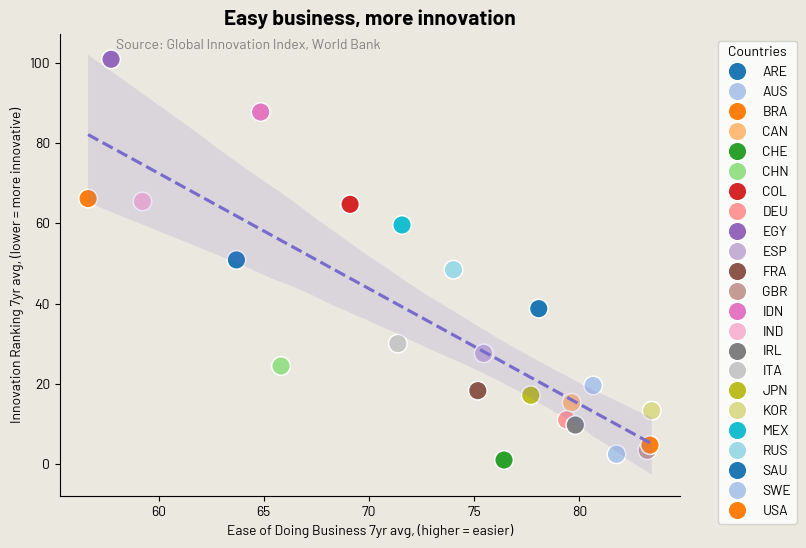

In [24]:
merge_df = ease_df.merge(innovation_df, left_on = ['country','date'], right_on =['country','year'], how ='inner')
merge_df.drop(columns=['date'],inplace=True)

plt.rcParams['font.family'] = 'Barlow'
fig, ax = plt.subplots(figsize=(8, 6))

sns.scatterplot(
    data=merge_grouped, 
    x="Ease_of_b", 
    y="innovation", 
    hue="country",            # Color points by 'species' column      # Set size based on 'petal_length'
    palette="tab20",
    s=180,           # Color palette
    alpha=1,
    ax=ax               # Set transparency
)
plt.grid(False)
sns.despine()
fig.subplots_adjust(top=0.88)
ax.set_facecolor((1, 1, 1, 0))
fig.patch.set_facecolor('#eae7ddf0')

sns.regplot(
    data=merge_grouped, x='Ease_of_b', y='innovation',
    scatter=False, color='#776bcd', line_kws={"linestyle":"--"}
)
ax.set_title("Easy business, more innovation",font='Barlow', fontsize=15, weight='bold')
ax.set_xlabel("Ease of Doing Business 7yr avg, (higher = easier)",font= 'Barlow', fontsize=10)
ax.set_ylabel("Innovation Ranking 7yr avg, (lower = more innovative)",font= 'Barlow', fontsize=10)
plt.legend(title="countries", loc='lower right')
fig.text(0.36, 0.86,"Source: Global Innovation Index, World Bank", 
         ha='center', va='center', fontsize=10, color='grey')
ax.legend(title="Countries", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


In [67]:

# Merge datasets
merge_df = ease_df.merge(innovation_df, left_on=['country', 'date'], right_on=['country', 'year'], how='inner')
merge_df.drop(columns=['date'], inplace=True)

# Scatterplot
scatter = alt.Chart(merge_grouped).mark_point(filled=True, size=180, opacity=1).encode(
    x=alt.X('Ease_of_b:Q', title='Ease of Doing Business 7yr avg (higher = easier)',scale=alt.Scale(domain=[50, 90])),
    y=alt.Y('innovation:Q', title='Innovation Ranking 7yr avg (lower = more innovative)'),
    color=alt.Color('country:N', legend=alt.Legend(title='Countries'), scale=alt.Scale(scheme='category20')),
    tooltip=['country', 'Ease_of_b', 'innovation']
)

# Combine scatterplot and regression line
chart = (scatter).properties(
    title={
        "text": ["Easy business, more innovation"],
        "subtitle": ["Source: Global Innovation Index, World Bank"],
        "fontSize": 20,
        "subtitleFontSize": 10,
        "subtitleFontStyle":"italic",
        "subtitleColor": "grey",
    },
    width=800,
    height=500,
    background='#eae7ddf0'
).configure(
    view={"strokeWidth": 0},  # Removes border
    legend={
        "titleFont": "Barlow",
        "labelFont": "Barlow",
        "orient": "bottom-right"
    },
    axis={
        "labelFont": "Barlow",
        "labelFontSize": 10,
        "titleFont": "Barlow",
        "titleFontSize": 10,
        "grid": False
    }
)

# Show the chart
chart.save('final_chart.json')



In [59]:

# Ensure numeric and non-null data
merge_grouped['Ease_of_b'] = pd.to_numeric(merge_grouped['Ease_of_b'], errors='coerce')
merge_grouped['innovation'] = pd.to_numeric(merge_grouped['innovation'], errors='coerce')
merge_grouped = merge_grouped.dropna(subset=['Ease_of_b', 'innovation'])

# Scatterplot
scatter = alt.Chart(merge_grouped).mark_point(filled=True, size=180, opacity=1).encode(
    x=alt.X('Ease_of_b:Q', title='Ease of Doing Business 7yr avg (higher = easier)', scale=alt.Scale(domain=[50, 90])),
    y=alt.Y('innovation:Q', title='Innovation Ranking 7yr avg (lower = more innovative)'),
    color=alt.Color('country:N', legend=alt.Legend(title='Countries'), scale=alt.Scale(scheme='category20')),
    tooltip=['country', 'Ease_of_b', 'innovation']
)

# Regression line
reg_line = alt.Chart(merge_grouped).transform_regression(
    'Ease_of_b', 'innovation'
).mark_line(color='#776bcd', strokeDash=[5, 5])

# Combine scatterplot and regression line
final_chart = (scatter + reg_line).properties(
    title={
        "text": ["Easy business, more innovation"],
        "subtitle": ["Source: Global Innovation Index, World Bank"],
        "fontSize": 15,
        "subtitleFontSize": 10,
        "subtitleColor": "grey",
    },
    width=800,
    height=500,
    background='#eae7ddf0'
).configure(
    view={"strokeWidth": 0},  # Removes border
    legend={
        "titleFont": "Barlow",
        "labelFont": "Barlow",
        "orient": "bottom-right"
    },
    axis={
        "labelFont": "Barlow",
        "labelFontSize": 10,
        "titleFont": "Barlow",
        "titleFontSize": 10,
        "grid": False
    }
)

# Show the chart
final_chart



alt.LayerChart(...)

In [28]:
merge_df

,country,Ease_of_b,year,innovation
0,ARE,80.75261,2019-01-01,36.0
1,ARE,81.58883,2018-01-01,38.0
2,ARE,79.30036,2017-01-01,35.0
3,ARE,77.43435,2016-01-01,41.0
4,ARE,76.28546,2015-01-01,47.0
...,...,...,...,...
156,USA,83.59008,2017-01-01,4.0
157,USA,83.58991,2016-01-01,4.0
158,USA,83.59247,2015-01-01,5.0
159,USA,82.58469,2014-01-01,6.0


TypeError: unsupported operand type(s) for *: 'Timestamp' and 'float'

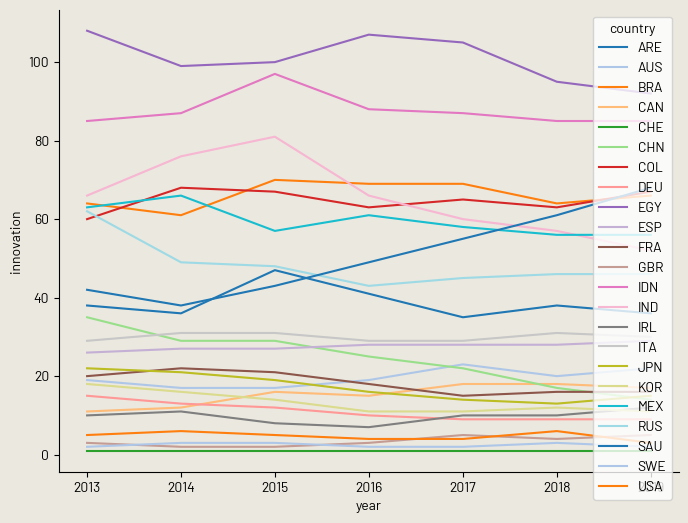

In [32]:
plt.rcParams['font.family'] = 'Barlow'
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(
    data=merge_df, 
    x="year", 
    y="innovation", 
    hue="country",            # Color points by 'species' column      # Set size based on 'petal_length'
    palette="tab20",
    alpha=1,
    ax=ax               # Set transparency
)
plt.grid(False)
sns.despine()
fig.subplots_adjust(top=0.88)
ax.set_facecolor((1, 1, 1, 0))
fig.patch.set_facecolor('#eae7ddf0')

sns.regplot(
    data=merge_df, x='year', y='innovation',
    scatter=False, color='#776bcd', line_kws={"linestyle":"--"}
)
ax.set_title("Innovation",font='Barlow', fontsize=15, weight='bold')
ax.set_xlabel("Year",font= 'Barlow', fontsize=10)
ax.set_ylabel("Innovation Ranking 7yr avg, (lower = more innovative)",font= 'Barlow', fontsize=10)
plt.legend(title="countries", loc='lower right')
fig.text(0.36, 0.86,"Source: Global Innovation Index, World Bank", 
         ha='center', va='center', fontsize=10, color='grey')
ax.legend(title="Countries", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [34]:
import altair as alt
import pandas as pd

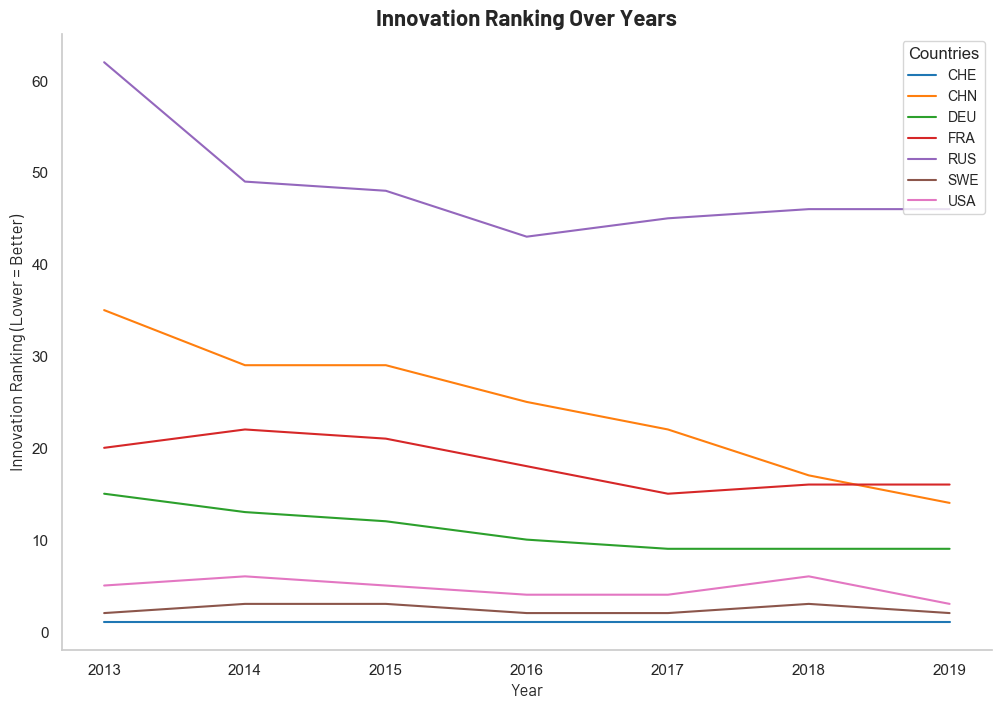

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data for the selected countries
filtered_countries = ['CHE', 'USA', 'FRA', 'DEU', 'RUS', 'CHN', 'SWE']
filtered_df = merge_df[merge_df['country'].isin(filtered_countries)]

# Set the style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=filtered_df,
    x='year', 
    y='innovation', 
    hue='country',
    palette="tab10",  # Adjust the color palette as needed
)

# Add labels, title, and legend
plt.title("Innovation Ranking Over Years", fontsize=16, weight='bold', family='Barlow')
plt.xlabel("Year", fontsize=12, family='Barlow')
plt.ylabel("Innovation Ranking (Lower = Better)", fontsize=12, family='Barlow')
plt.legend(title="Countries", loc='upper right', fontsize=10)

# Final adjustments
plt.grid(visible=False)
sns.despine()
plt.show()


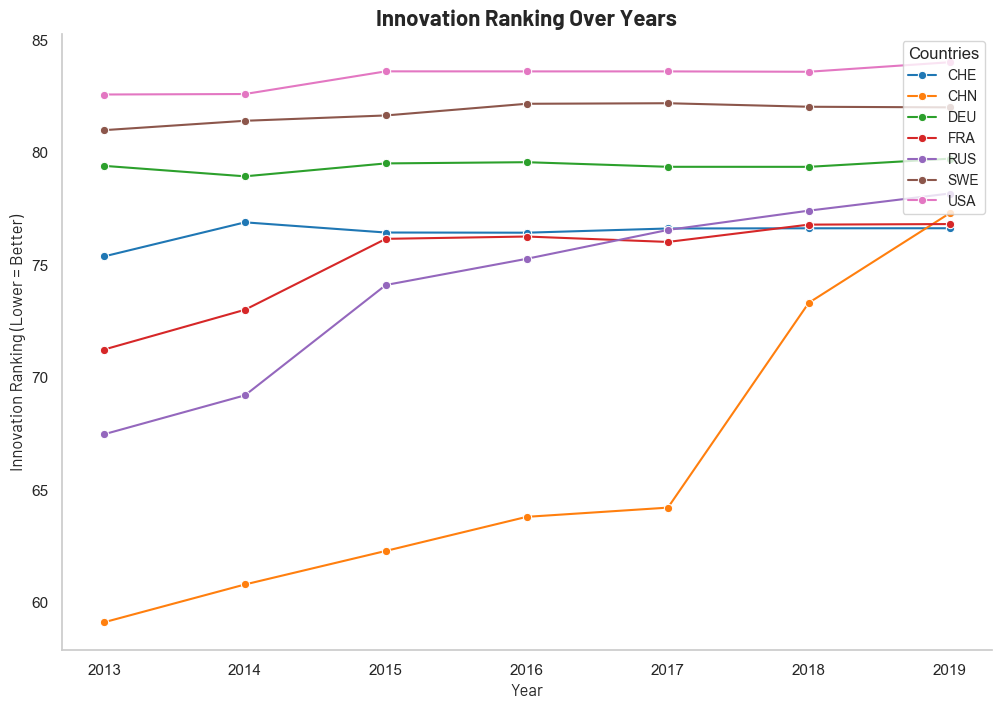

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data for the selected countries
filtered_countries = ['CHE', 'USA', 'FRA', 'DEU', 'RUS', 'CHN', 'SWE']
filtered_df = merge_df[merge_df['country'].isin(filtered_countries)]

# Set the style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=filtered_df,
    x='year', 
    y='Ease_of_b', 
    hue='country',
    palette="tab10",  # Adjust the color palette as needed
    marker="o"
)

# Add labels, title, and legend
plt.title("Innovation Ranking Over Years", fontsize=16, weight='bold', family='Barlow')
plt.xlabel("Year", fontsize=12, family='Barlow')
plt.ylabel("Innovation Ranking (Lower = Better)", fontsize=12, family='Barlow')
plt.legend(title="Countries", loc='upper right', fontsize=10)

# Final adjustments
plt.grid(visible=False)
sns.despine()
plt.show()

In [42]:


# Filter the data for the specified countries
filtered_countries = ['CHE', 'USA', 'FRA', 'DEU', 'RUS', 'CHN', 'SWE']
filtered_df = merge_df[merge_df['country'].isin(filtered_countries)]
filtered_df['year'] = pd.to_datetime(filtered_df['year'], errors='coerce')
filtered_df['innovation'] = pd.to_numeric(filtered_df['innovation'], errors='coerce')
filtered_df = filtered_df.dropna(subset=['innovation'])

# Line chart
line_chart = alt.Chart(filtered_df).mark_line().encode(
    x=alt.X('year:T', title='Year'),
    y=alt.Y('innovation:Q', title='Innovation Ranking 7yr avg (lower = more innovative)'),
    color=alt.Color('country:N', legend=alt.Legend(title='Countries'), scale=alt.Scale(scheme='category20')),
    tooltip=['year:T', 'country:N', 'innovation:Q']
).properties(
    width=800,
    height=500
)

# Regression line
reg_line = alt.Chart(filtered_df).mark_line(strokeDash=[5, 5], color='#776bcd').transform_regression(
    'year', 'innovation', groupby=['country']
)

# Combine line chart and regression line
final_chart = (line_chart + reg_line).properties(
    title={
        "text": ["Innovation"],
        "subtitle": ["Source: Global Innovation Index, World Bank"],
        "fontSize": 15,
        "subtitleFontSize": 10,
        "subtitleColor": "grey",
    },
    background='#eae7ddf0'  # Chart background color
).configure(
    view={"strokeWidth": 0},  # Removes border
    legend={
        "titleFont": "Barlow",
        "labelFont": "Barlow"
    },
    axis={
        "labelFont": "Barlow",
        "labelFontSize": 10,
        "titleFont": "Barlow",
        "titleFontSize": 10,
        "grid": False  # Removes grid lines
    }
)

# Show the chart
final_chart



/var/folders/dx/505c01650qnflnz6sd29qqsh0000gn/T/ipykernel_24011/2650163356.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['year'] = pd.to_datetime(filtered_df['year'], errors='coerce')
/var/folders/dx/505c01650qnflnz6sd29qqsh0000gn/T/ipykernel_24011/2650163356.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['innovation'] = pd.to_numeric(filtered_df['innovation'], errors='coerce')


alt.LayerChart(...)

In [ ]:
innovation_df

,country,year,innovation
0,ARE,2013-01-01,38.0
1,ARE,2014-01-01,36.0
2,ARE,2015-01-01,47.0
3,ARE,2016-01-01,41.0
4,ARE,2017-01-01,35.0
...,...,...,...
156,USA,2015-01-01,5.0
157,USA,2016-01-01,4.0
158,USA,2017-01-01,4.0
159,USA,2018-01-01,6.0


In [ ]:
countries = ['USA','FRA','GBR','DEU','SWE','JPN','CHN','CHE','IND']


json_data = innovation_df.to_json(orient='records')

charts = []


for i in countries:
    subset = innovation_df[innovation_df['country']==i]
    chart = alt.Chart(subset).mark_line(point=True).encode(
        x=alt.X('year', title='Year'),
        y=alt.Y('innovation:Q',title='Innovation Rank'),
        color='country:N'
    ).properties(
        title=f"World Innovation Index ranking {i}",
        width = 600,
        height = 300
    )
    charts.append(chart)
rows = []
n_cols = 4  # Number of charts per row
for i in range(0, len(charts), n_cols):
    row = alt.hconcat(*charts[i:i + n_cols])  # Horizontally concatenate n_cols charts
    rows.append(row)

# Vertically concatenate all rows
dashboard = alt.vconcat(*rows).configure(
    background="#eae7dd",  # Background color for the entire dashboard
    font="Barlow",         # Font for the entire dashboard
    title={
        "fontSize": 16,    # Title font size
        "font": "Barlow",  # Title font
    },
    axis={
        "labelFont": "Barlow",  # Font for axis labels
        "labelFontSize": 12,    # Axis label size
        "titleFont": "Barlow",  # Font for axis titles
        "titleFontSize": 14,    # Axis title size
    }
    ).configure_view(
            fill="#eae7dd",  # Background color for each chart
            strokeWidth=0  # Remove the border around the chart  
    ).configure_axis(
    grid=False  # Turn off all gridlines globally
    )

dashboard.show()

alt.VConcatChart(...)

CHANGE HERE THIS IS SOMETHING ELSE

In [ ]:
df_gni = df_gni.reset_index()

In [ ]:

df_gni = df_gni.query('economy == ("CHE","USA","EUU","FRA")')
df_gni_long = df_gni.melt(id_vars=['Country', 'economy'], var_name='date', value_name='GNI_per_capita') 
df_gni_long['date'] = df_gni_long['date'].str.replace('YR', '')
df_gni_long = df_gni_long.drop(df_gni_long[df_gni_long['date'] == 'index'].index)
df_gni_long['date'] = pd.to_numeric(df_gni_long['date'])
df_gni_long = df_gni_long.drop(df_gni_long[df_gni_long['date'] < 1980].index)
df_gni_long['date'] = pd.to_datetime(df_gni_long['date'], format='%Y')
df_gni_long = df_gni_long.dropna()
df_gni_long

,Country,economy,date,GNI_per_capita
80,United States,USA,1980-01-01,13390.000000
81,Switzerland,CHE,1980-01-01,22320.000000
82,France,FRA,1980-01-01,13100.000000
83,European Union,EUU,1980-01-01,8391.748603
84,United States,USA,1981-01-01,14360.000000
...,...,...,...,...
251,European Union,EUU,2022-01-01,40157.776770
252,United States,USA,2023-01-01,80300.000000
253,Switzerland,CHE,2023-01-01,95160.000000
254,France,FRA,2023-01-01,45070.000000


In [ ]:
import altair as alt


In [ ]:


# Create the line chart
chart = alt.Chart(df_gni_long).mark_line().encode(
    x='date:T',  
    y='GNI_per_capita:Q',  
    color='Country:N'
).properties(
    width=600,
    height=400,
    title="Multiple line GNI plot"
)

chart.show()

alt.Chart(...)